<a href="https://colab.research.google.com/github/elhamod/BA865-2024/blob/main/hands-on/First_Pytorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now, that you know how to train an MLP, let's make minor changes to train a

##Things we will investigate:

- How to construct a CNN.
- How to load data from disk
- How to do image transformations.
- How to fine-tune a pre-trained model.
- How to handle class imbalance.
- The effects of hyper-parameters:
  - kernel size, padding, and stride.
  - number of layers and number of filters in each layer.
- How to tune hyper-parameters with WandB.


Here are some flags that you can turn on and off

In [ ]:
enable_wandb = True
use_gpu = True

##Import some packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

This helps you check if GPU is available

In [ ]:
gpu_available = torch.cuda.is_available()
gpu_available

True

Some extra fancy but optional packages:

- `torchmetrics` for calculating accuracy
- `wandb` for logging

In [ ]:
if enable_wandb:
  !pip install wandb -qU
  import wandb
  wandb.login()

wandb: Currently logged in as: mndhamod (phylonn). Use `wandb login --relogin` to force relogin


## Hyper-parameters

Define your hyper-parameters here.

In [ ]:
# Hyperparameters

experiment_name = "experiment_good_CNN"

# Data
img_dimensions = (1,28,28)
output_size = 10  # 10 classes for the digits 0-9
batch_size = 128

# CNN
filter_sizes = [4,8]
kernel_size = 5
stride= 2
padding=1

#Optimzation
learning_rate = 0.001
epochs = 10
weight_decay = 0.001


## Data

Load your dataset and create `DataLoaders` that handle the batching and shuffling.

In [ ]:
# Transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Define and create your model

In [ ]:
# MLP model
class MLP(nn.Module):
    def __init__(self, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            torch.nn.Conv2d(img_dimensions[0], filter_sizes[0], kernel_size, stride=stride, padding=padding),
            torch.nn.ReLU(),
            torch.nn.Conv2d(filter_sizes[0], filter_sizes[1], kernel_size, stride=stride, padding=padding),
            torch.nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(72, 10) # We can determine the 72 here by doing calculations offline or looking at the error.
        )

    # Defines the forward pass.
    def forward(self, x):
        x = x.view(-1, img_dimensions[0], img_dimensions[1], img_dimensions[1])
        return self.model(x)


Adding `.cuda` moves your model to the GPU.

In [ ]:
model = MLP( output_size)
if gpu_available and use_gpu:
  model = model.cuda()

use `torch-summary` for more info on the model

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

summary(model, (28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 4, 13, 13]            104
│    └─ReLU: 2-2                         [1, 4, 13, 13]            --
│    └─Conv2d: 2-3                       [1, 8, 6, 6]              808
│    └─MaxPool2d: 2-4                    [1, 8, 3, 3]              --
│    └─Flatten: 2-5                      [1, 72]                   --
│    └─Linear: 2-6                       [1, 10]                   730
Total params: 1,642
Trainable params: 1,642
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

## Loss

For classification, we use cross-entropy.

In [ ]:
criterion = nn.CrossEntropyLoss()

##Optimizer

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Training!

In [ ]:
if enable_wandb:
  wandb.init(
    # Set the project where this run will be logged
    project="First PyTorch NN",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=experiment_name,
    # Track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "epochs": epochs,
    "batch_size": batch_size,
    "weight_decay": weight_decay,
    "notes for me": "This is a CNN"
    })

Define some functions to calculate training and test accuracies

In [ ]:
## There is a package called torchmetrics that makes calculating accuracy easier.
## Feel free to use it. However, here, I show the logic behind such calculations
# !pip install -U torchmetrics
# import torchmetrics

def get_accuracy(dataloader, model):
  acc = 0
  # <OR>
  # acc = torchmetrics.Accuracy()

  with torch.no_grad():
      for images, labels in dataloader:
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          outputs = model(images) # get predictions

          # Update accuracy for this batch
          acc = acc + torch.sum(torch.argmax(outputs, axis=1) == labels)
          # <OR>
          # acc.update(outputs, labels)


      # Compute the accuracy
      acc = acc/len(dataloader.dataset) # normalizes
      # <OR>
      # acc = acc.compute()

      return acc



In [ ]:
def get_loss(loader):
  with torch.no_grad(): # Anything under torch.no_grad will be calculated with no gradients. Can only be used for testing, not training!

    loss = 0
    for i, (images, labels) in enumerate(loader): # The batches.
          # step1: Move data to cuda. Make sure the model is on cuda too!
          if gpu_available and use_gpu:
            images = images.cuda()
            labels = labels.cuda()

          # step2: Forward pass
          outputs = model(images)

          # step 3: calculate the loss.
          loss = loss + criterion(outputs, labels)
    return loss/ len(loader.dataset)

Early-stopping class

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        # If the new loss is lower than the old loss, reset the counter!
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Keep track of the best model by saving it on the hard drive.
            torch.save(model.state_dict(), "./best_model.pt")
        # otherwise, increment the counter.
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            # If there has been too many epochs with the loss being high, terminate.
            if self.counter >= self.patience:
                return True
        return False


Train!

In [ ]:
early_stopper = EarlyStopper(patience=3)

# Training loop
for epoch in range(epochs): # The epochs.
    for i, (images, labels) in enumerate(train_loader): # The batches.
        # step 1: Zero out the gradients.
        optimizer.zero_grad()

        # step 1.1 move data to cuda. Make sure the model is on cuda too!
        if gpu_available and use_gpu:
          images = images.cuda()
          labels = labels.cuda()

        # step2: Forward pass
        outputs = model(images)

        # step 3: calculate the loss.
        loss = criterion(outputs, labels)

        # step 4: Backward pass
        loss.backward()
        optimizer.step()

        # Print the loss
        if i %100 == 0:
          print("Epoch", epoch+ 1, " batch", i+1, ". Training Loss: ", loss.item())
          if enable_wandb:
            wandb.log({"loss": loss})

    # Compute total train accuracy
    train_acc = get_accuracy(train_loader, model)
    test_acc = get_accuracy(val_loader, model)

    print(f'Epoch [{epoch + 1}/{epochs}], Train Accuracy: {train_acc.item():.4f}, Validation Accuracy: {test_acc.item():.4f}')
    if enable_wandb:
      wandb.log({"epoch": epoch + 1, "train_accuracy": train_acc.item(), "val_accuracy": test_acc.item()})

    validation_loss = get_loss(val_loader)
    if early_stopper.early_stop(validation_loss):
        print("Validation loss hasn't dropped. Early stopping!")
        break



Epoch 1  batch 1 . Training Loss:  2.3838744163513184
Epoch 1  batch 101 . Training Loss:  0.8625868558883667
Epoch 1  batch 201 . Training Loss:  0.3091260492801666
Epoch 1  batch 301 . Training Loss:  0.3934383690357208
Epoch [1/10], Train Accuracy: 0.9262, Validation Accuracy: 0.9257
Epoch 2  batch 1 . Training Loss:  0.34151744842529297
Epoch 2  batch 101 . Training Loss:  0.22842855751514435
Epoch 2  batch 201 . Training Loss:  0.23029115796089172
Epoch 2  batch 301 . Training Loss:  0.1623344123363495
Epoch [2/10], Train Accuracy: 0.9498, Validation Accuracy: 0.9509
Epoch 3  batch 1 . Training Loss:  0.20767250657081604
Epoch 3  batch 101 . Training Loss:  0.17709004878997803
Epoch 3  batch 201 . Training Loss:  0.2389821708202362
Epoch 3  batch 301 . Training Loss:  0.0938965231180191
Epoch [3/10], Train Accuracy: 0.9608, Validation Accuracy: 0.9601
Epoch 4  batch 1 . Training Loss:  0.053311094641685486
Epoch 4  batch 101 . Training Loss:  0.11742089688777924
Epoch 4  batch 201

Test

In [ ]:
print("last model performance on Test set:", get_accuracy(test_loader, model))

# Once training is done, load the best model (might not be the last model due to early stopping)
model.load_state_dict(torch.load("./best_model.pt"))
acc = get_accuracy(test_loader, model)
print("best model performance Test set:", acc)

if enable_wandb:
  wandb.summary['Test Accuracy'] = acc.item()

last model performance on Test set: tensor(0.9725, device='cuda:0')
best model performance Test set: tensor(0.9725, device='cuda:0')


Test

In [ ]:
if enable_wandb:
  wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▆▇▇▇████
val_accuracy,▁▅▆▇▇▇████
Test Accuracy,0.9725
epoch,10
loss,0.06673
train_accuracy,0.9744
val_accuracy,0.97175


Wandb result (Try it yourself!)
See how CNN is better than MLP even though it has ~1% of number of weights.

https://api.wandb.ai/links/phylonn/nrzpdguz

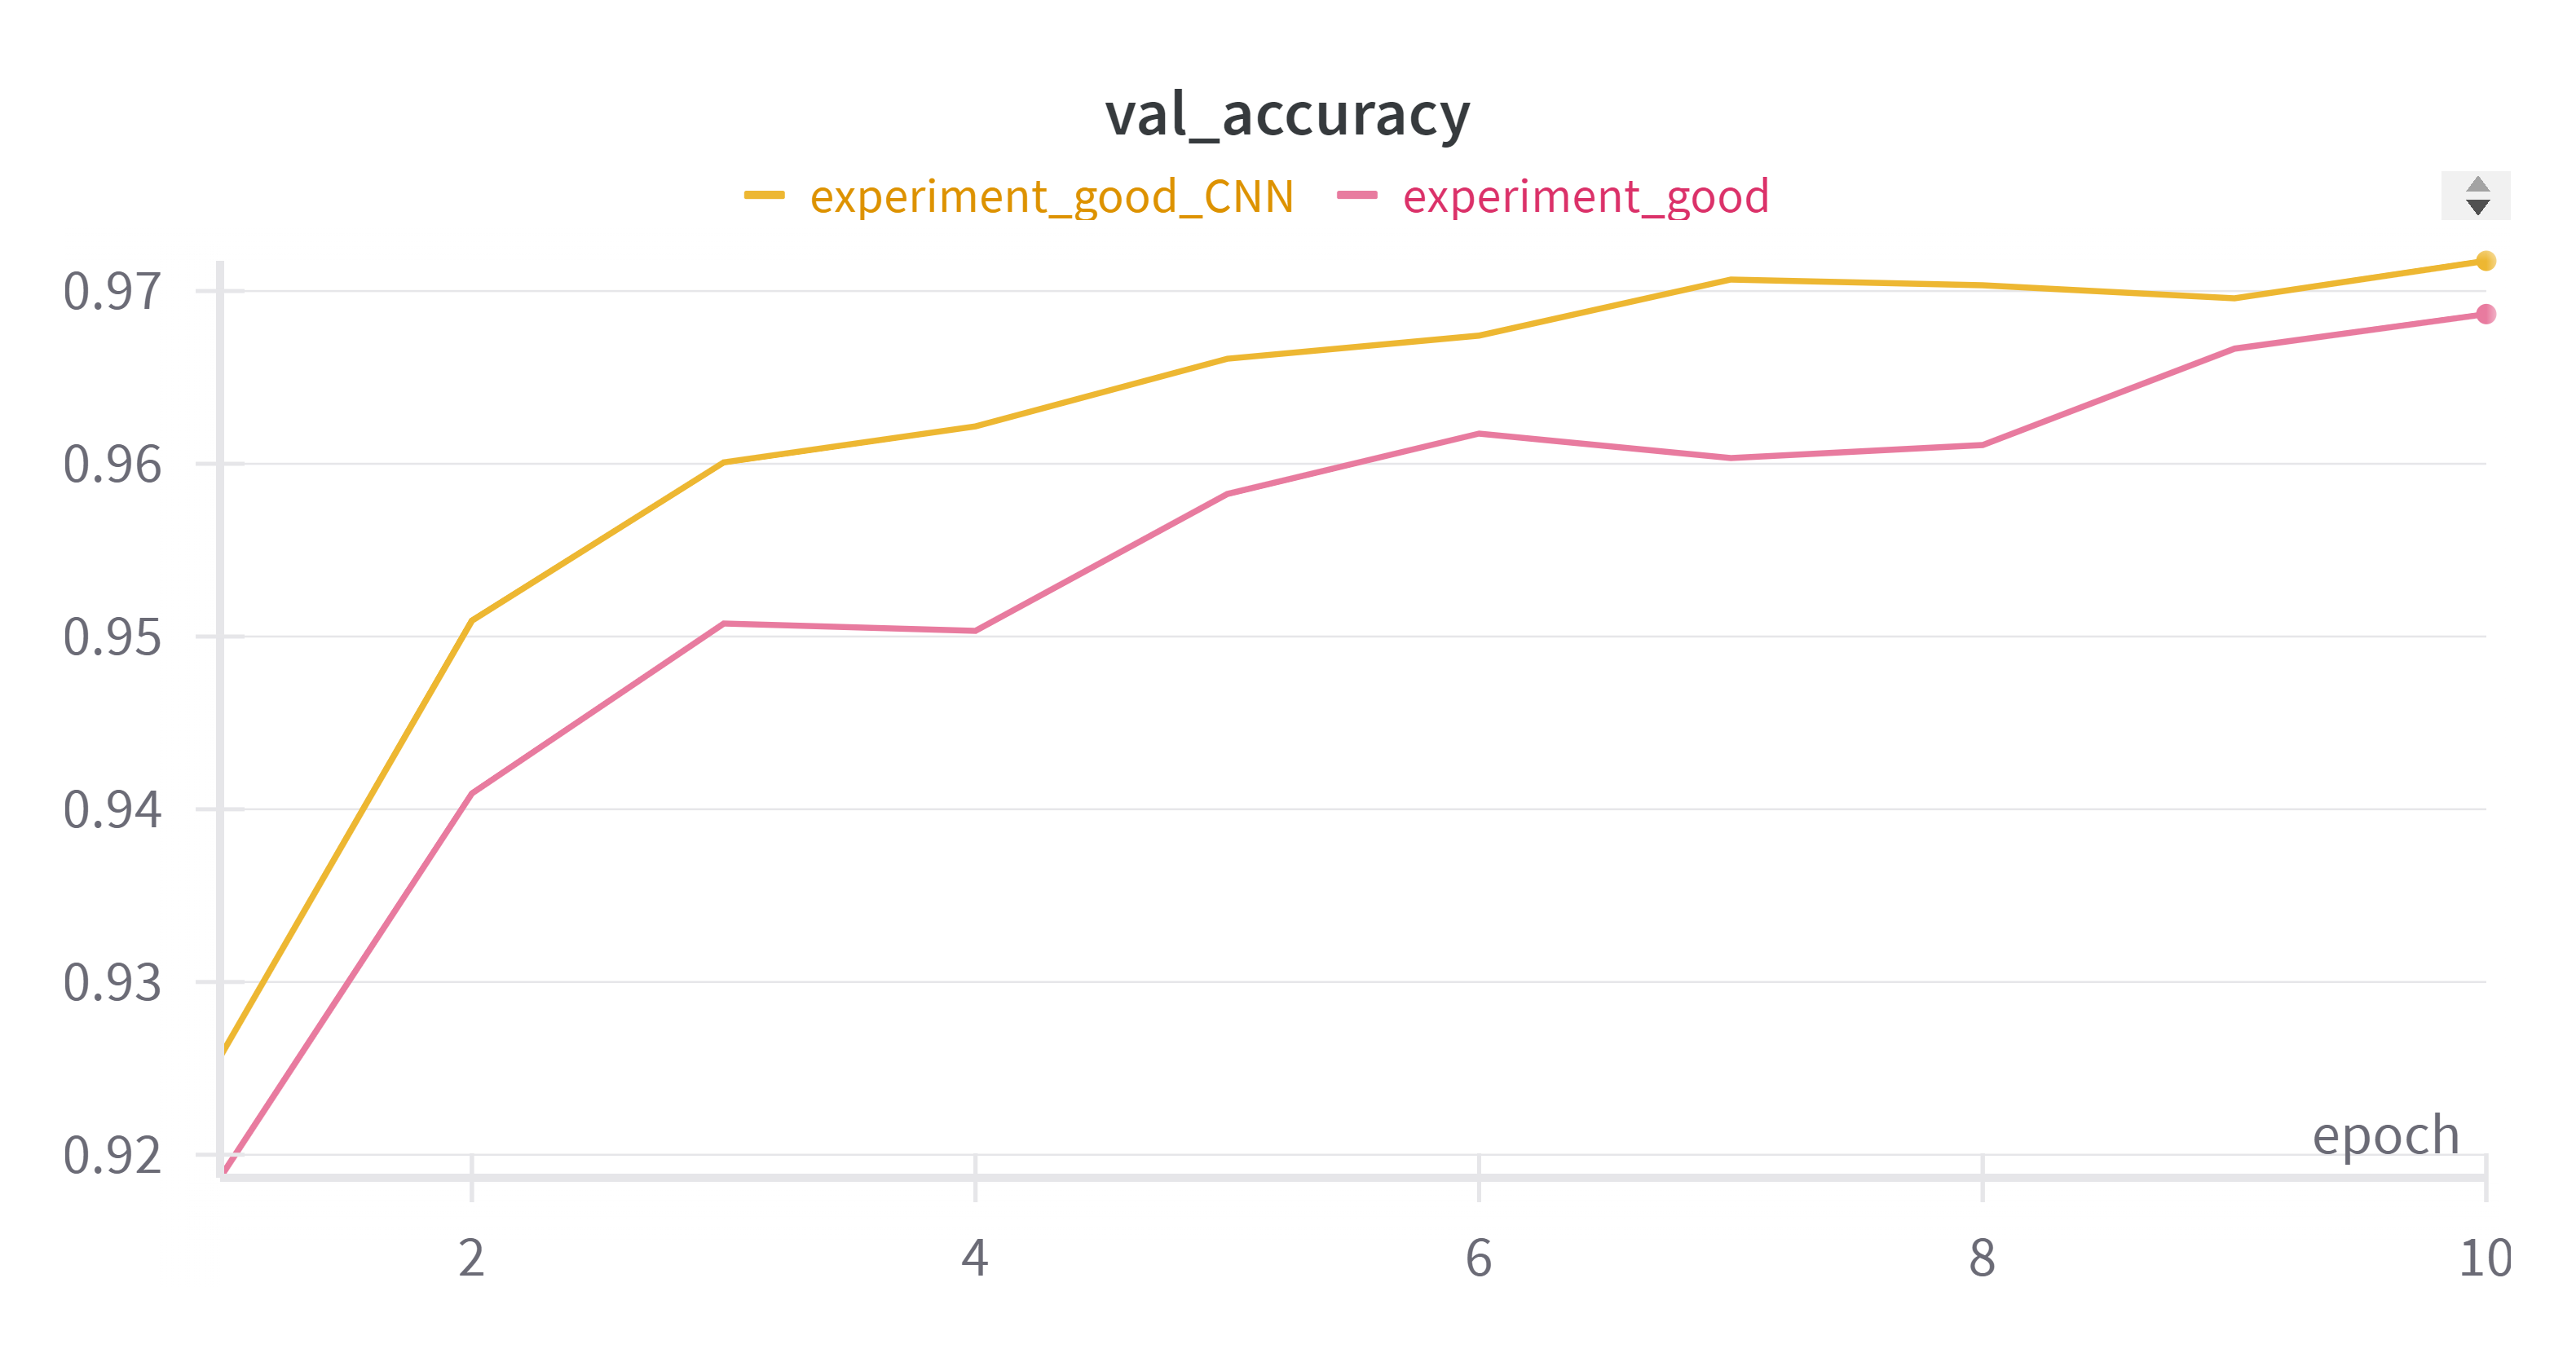

